# Quantile Regression for Differences

Attempt to use quantile regression for predicting one step ahead

The process this notebook follows is:

* Estimate true 2nd derivative from noisy data
* Fit QR GBM to data
* Make predictions and run simulations


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qr_simulation import QuantileRegressionSimulator
from scipy.integrate import solve_ivp
import seaborn as sns 

plt.style.use("ggplot")


c:\Users\robert.robison\.virtualenvs\ar_forecasting\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-29 14:58:23,725 [INFO] 
Limited Total Variation Regularization Support Detected! 
---> CVXPY is not installed. 
---> Many Total Variation Methods require CVXPY including: 
---> velocity, acceleration, jerk, jerk_sliding, smooth_acceleration
---> Please install CVXPY to use these methods.
---> Recommended to also install MOSEK and obtain a MOSEK license.
You can still use: total_variation_regularization.iterative_velocity

2023-05-29 14:58:23,732 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 

2023-05-29 14:58:23,733 [INFO] 
Limited Linear Model Suppo

## Pendulum

### Gen Data

In [9]:

def pendulum_actual(t, state, p):
    # state = [theta, theta_d]

    # Parameters
    mu, L = p

    # Calc derivatives
    theta_d = state[1]
    theta_dd = 9.8 * np.sin(state[0]) / L - mu * state[1]

    return np.array([theta_d, theta_dd])

# Set initial conditions and parameters
tspan = (0, 100)
tspan = (0, 35)
X0 = np.array([
    [0.524, 1.57, -1.0, -2.5, 0.0, -0.25],  # theta
    [0.0, -1.0, 1.0, 2.0, 0.5, 3.0],  # theta_d
])
X0 = np.array([[0.524], [0.0]])  # 30 degrees, at rest
p = [0.02, 1.0]

# solve ODE
t = np.linspace(*tspan, 10000)
t = np.linspace(*tspan, round(tspan[1] * 100))
# res = solve_ivp(pendulum_actual, tspan, X0, args=[p], dense_output=True)
res_list = []
noise = 1.0
empty_row = pd.DataFrame({"theta": [np.nan], "theta_d": [np.nan]})
for i in range(X0.shape[1]):
    res = solve_ivp(pendulum_actual, tspan, X0[:, i], args=[p], dense_output=True)
    curr_data = pd.DataFrame(res.sol(t).T + noise * np.random.normal(size=(t.shape[0], 2)), columns=["theta", "theta_d"])
    curr_data_ = pd.DataFrame(res.sol(t).T, columns=["theta_", "theta_d_"])
    res_list.append(pd.concat([curr_data, curr_data_], axis=1))
    # res_list.append(empty_row)
data = pd.concat(res_list)
data["theta_dd_"] = [pendulum_actual(0, data[["theta_", "theta_d_"]].iloc[i].tolist(), p)[1] for i in range(data.shape[0])]
data


,theta,theta_d,theta_,theta_d_,theta_dd_
0,1.177479,0.090968,0.524000,0.000000,4.903405
1,0.691035,1.063659,0.524245,0.049050,4.904505
2,0.157342,-0.095838,0.524981,0.098132,4.909767
3,-2.488444,-1.030775,0.526209,0.147288,4.919187
4,-0.026352,-0.320377,0.527927,0.196559,4.932759
...,...,...,...,...,...
3495,2.574929,-1.890713,1.928548,-2.725806,9.234044
3496,3.376316,-2.742377,1.901742,-2.632671,9.320863
3497,0.656901,-1.018354,1.875872,-2.538764,9.398252
3498,2.768131,-1.762115,1.850947,-2.444210,9.466819


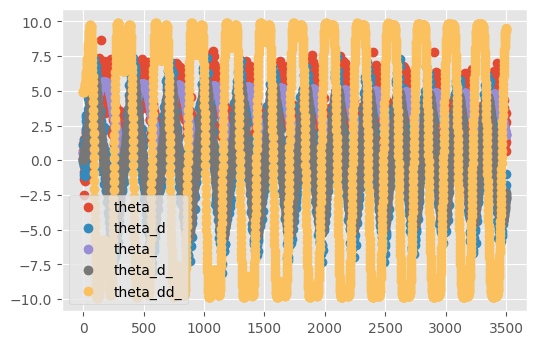

In [10]:
fig, ax = plt.subplots(dpi=100)
data.plot(ax=ax, ls="", marker="o")

plt.show()


### Model data

In [11]:
qr = QuantileRegressionSimulator(
    data[["theta"]],
    m_factor=10,
    random_state=5,
    n_diff=2,
    freq=1/3,
    dt=0.01,
)
qr.train()


[I 2023-05-29 15:03:44,661] A new study created in memory with name: no-name-ad63f5a2-31a1-4f36-bb39-bd3ac3fcb8ec


Running hyperparameter tuning for model 1...


c:\Users\robert.robison\.virtualenvs\ar_forecasting\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-05-29 15:03:49,326] Trial 0 finished with value: 1.2748170336039555 and parameters: {'num_iterations': 338, 'learning_rate': 0.13282626213961868, 'use_early_stopping': 0, 'early_stopping_round': 60, 'lambda_l1': 0.0003631728689512689, 'lambda_l2': 5.706880334944421, 'num_leaves': 261, 'min_child_samples': 14}. Best is trial 0 with value: 1.2748170336039555.
[I 2023-05-29 15:03:52,431] Trial 1 finished with value: 1.2757303540262406 and parameters: {'num_iterations': 320, 'learning_rate': 0.12063697128578216, 'use_early_stopping': 0, 'early_stopping_round': 48, 'lambda_l1': 0.0005154720153796029, 'lambda_l2': 2.7621160018791913, 'num_leaves': 267, 'min_child_samples': 78}. Best is trial 0 with value: 1.2748170336039555.
[I 2023-05-2

Number of finished trials: 100
Best trial:
  Value: 1.2341016855385438
  Params: 
    num_iterations: 339
    learning_rate: 0.2997305899315568
    use_early_stopping: 0
    early_stopping_round: 68
    lambda_l1: 0.00018435075452800318
    lambda_l2: 1.6620637808673453
    num_leaves: 473
    min_child_samples: 6


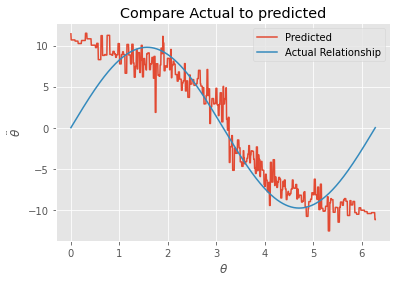

In [12]:
fig, ax = plt.subplots()
theta_vals = np.linspace(0, 2 * np.pi, 1000)
x = np.hstack((theta_vals.reshape(-1, 1), np.repeat(.5, 1000).reshape(-1, 1)))
pred_vals = qr.models[0].predict(x)
ax.plot(theta_vals, pred_vals, label="Predicted")
ax.plot(theta_vals, 9.8 * np.sin(theta_vals), label="Actual Relationship")
ax.set_title("Compare Actual to predicted")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\ddot{\theta}$")
ax.legend()
plt.show()

,theta_0.2
0.010003,5.776809
0.020006,4.618933
0.030009,5.486523
0.040011,7.606964
0.050014,5.536851


,theta_0.5
0.010003,10.146523
0.020006,8.805855
0.030009,10.256582
0.040011,13.814025
0.050014,11.440745


,theta_0.8
0.010003,12.989602
0.020006,11.202388
0.030009,12.765407
0.040011,16.979933
0.050014,14.762801


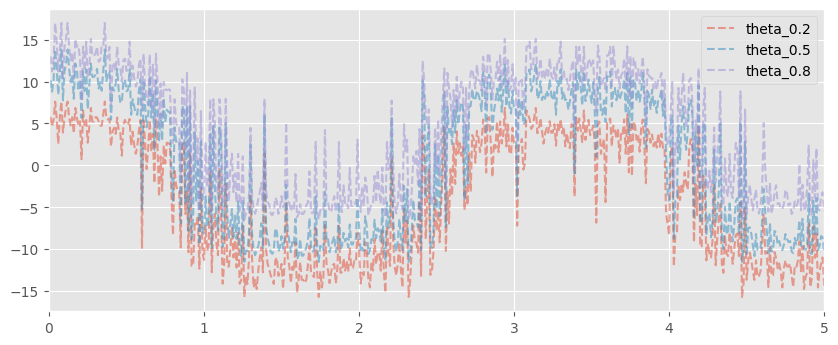

In [13]:
alpha = [0.2, 0.5, 0.8]
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
for a in alpha:
    pred = qr.predict(data.iloc[:len(t), [0]], alpha=a)
    pred_df = pd.DataFrame(pred, columns=[f"{col}_{a}" for col in ["theta"]])
    # pred_df = pd.DataFrame(pred + data.to_numpy(), columns=[f"{col}_{a}" for col in data.columns])
    pred_df = pred_df.iloc[:-1]
    pred_df.index=t[1:]
    pred_df.plot(ax=ax, ls="--", alpha=0.5)
    display(pred_df.head())
# ax.plot(t, ((data - data.shift(1) - (data.shift(1) - data.shift(2)))).iloc[:len(t), 0])
# ax.plot(t, (data - data.shift()).iloc[:len(t), 1])
ax.set_xlim(0, 5)
# ax.set_xlim(20, 40)
plt.show()

In [14]:
from tqdm import tqdm


nsims = 50
sims = np.zeros((nsims, len(t), data.shape[1]))
X0 = data.copy().iloc[0].to_numpy()
X0=data.iloc[1, [0]].to_numpy()
X0_prev=data.iloc[0, [0]].to_numpy()
for i in tqdm(range(nsims)):
    sims[i, ...] = qr.simulate_path(X0=X0, steps=len(t), sample=True, X0_prev=X0)
    # sims[i, ...] = qr.simulate_path(data.iloc[0].to_numpy(), len(t), sample=True)
    

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


In [15]:
median_sim = qr.simulate_path(X0=X0, steps=len(t), sample=False, X0_prev=X0)

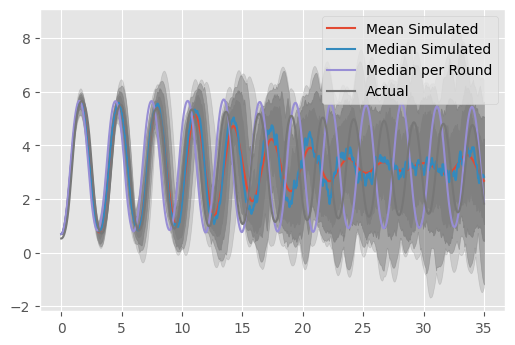

In [19]:
fig, ax = plt.subplots(dpi=100)
alpha = [0.5, 0.8, 0.95, 0.995]
for i, a in enumerate(reversed(sorted(alpha))):
    a2 = (1 - a) / 2
    ax.fill_between(t, y1=np.quantile(sims[..., 0], a2, axis=0), y2=np.quantile(sims[..., 0], 1 - a2, axis=0), alpha=0.25 * (i + 1), color="gray", label="")
# for i in range(nsims):
#     ax.plot(t, sims[i, :, 0], label="", c="gray", alpha=0.25)
ax.plot(t, sims[:, :, 0].mean(axis=0), label="Mean Simulated")
ax.plot(t, np.median(sims[:, :, 0], axis=0), label="Median Simulated")
ax.plot(t, median_sim[:, 0], label="Median per Round")
ax.plot(t, data.theta_.iloc[:], label="Actual")
ax.legend()
plt.show()


## Cartpole

### Gen Data

In [153]:
def cartpole(t, u, p):
    # u = [theta, theta_d, x, x_d]

    # external force
    # force = -0.2+0.5*np.sin(6*t)
    force = 0

    # Parameters
    m0, m1, gravity, length, mu_c, mu_p, k_inertia = p

    du = np.zeros(4)

    # theta_d
    du[0] = u[1]

    # theta_dd
    du[1] = (
        (m0 + m1) * gravity * np.sin(u[0])
        - np.cos(u[0]) * (force + m1 * length * (u[1] ** 2) * np.sin(u[0]) - mu_c * u[3])
        - ((m0 + m1) * mu_p * u[1]) / (m1 * length)
    ) / ((m0 + m1) * (k_inertia + 1) * length - m1 * length * (np.cos(u[0])) ** 2)

    # x_d
    du[2] = u[3]

    # x_dd
    du[3] = (
        force
        - m1 * length * (du[1] * np.cos(u[0]) - (u[1] ** 2) * np.sin(u[0]))
        - mu_c * u[3]
    ) / (m0 + m1)

    return du


# Parameters
p = (1.5, 1.0, 9.8, 1.0, 0.05, 0.05, 1 / 3)

# Initial conditions
X0 = np.array([0.524, 0.0, 0.0, 0.5])  # 30 degrees, 2 m/s to the right


# solve ODE
tspan = (0, 35)
t = np.linspace(*tspan, round(tspan[1] * 100))
res = solve_ivp(cartpole, tspan, X0, args=[p], dense_output=True)
noise = 0.1
sol_data = res.sol(t).T
cdata = pd.DataFrame(sol_data + noise * np.random.normal(size=(t.shape[0], 4)), columns=["theta", "theta_d", "x", "x_d"])
cdata_ = pd.DataFrame(sol_data, columns=["theta_", "theta_d_", "x_", "x_d_"])
cdata = pd.concat([cdata, cdata_], axis=1)


<AxesSubplot:>

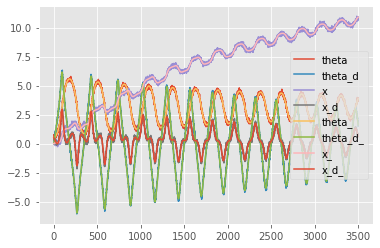

In [154]:
cdata.plot()

### Model Data

In [155]:
qr = QuantileRegressionSimulator(
    cdata[["theta", "x"]],
    m_factor=100,
    random_state=5,
    n_diff=2,
    freq=1/3,
    dt=0.01,
)
qr.train()


[I 2023-05-29 21:57:16,176] A new study created in memory with name: no-name-2af09709-1b7d-421d-8fea-7ea9fc2ccbcc


Running hyperparameter tuning for model 1...


c:\Users\robert.robison\.virtualenvs\ar_forecasting\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-05-29 21:57:42,422] Trial 0 finished with value: 0.0034047220984929475 and parameters: {'num_iterations': 1000, 'learning_rate': 0.001}. Best is trial 0 with value: 0.0034047220984929475.


Number of finished trials: 1
Best trial:
  Value: 0.0034047220984929475
  Params: 
    num_iterations: 1000
    learning_rate: 0.001


[I 2023-05-29 21:57:43,190] A new study created in memory with name: no-name-bfc49547-3de0-460d-9cad-fd18afbdec31


Running hyperparameter tuning for model 2...


[I 2023-05-29 21:58:07,023] Trial 0 finished with value: 0.0012471272972082344 and parameters: {'num_iterations': 1000, 'learning_rate': 0.001}. Best is trial 0 with value: 0.0012471272972082344.


Number of finished trials: 1
Best trial:
  Value: 0.0012471272972082344
  Params: 
    num_iterations: 1000
    learning_rate: 0.001


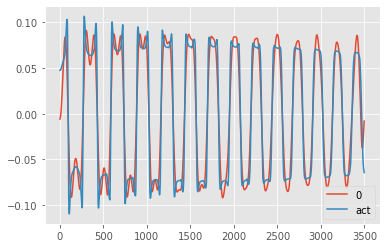

In [156]:
fig, ax = plt.subplots()
pd.DataFrame(qr.y_all)[0].plot()
ax.plot(cdata.theta_d_.shift(-1) - cdata.theta_d_, label="act")
ax.legend()

2023-05-29 21:58:08,699 [WARNING] No handles with labels found to put in legend.


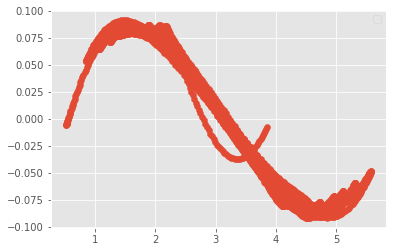

In [157]:
fig, ax = plt.subplots()
ax.scatter(cdata.theta_.iloc[1:-1], pd.DataFrame(qr.y_all)[0])
# ax.plot(cdata.theta_d_.shift(-1) - cdata.theta_d_, label="act")
ax.legend()

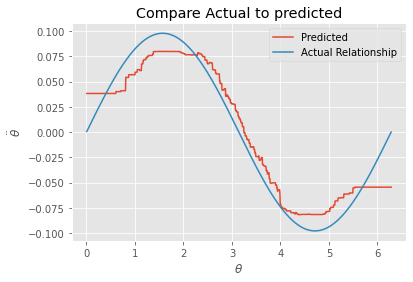

In [158]:
fig, ax = plt.subplots()
theta_vals = np.linspace(0, 2 * np.pi, 1001)

x = np.hstack((theta_vals[1:].reshape(-1, 1), np.repeat(0, 1000).reshape(-1, 1), (theta_vals[1:] - theta_vals[:-1]).reshape(-1, 1), np.repeat(0, 1000).reshape(-1, 1), np.repeat(.5, 1000).reshape(-1, 1)))
pred_vals = qr.models[0].predict(x)
ax.plot(theta_vals[1:], pred_vals, label="Predicted")
ax.plot(theta_vals[1:], 9.8 * np.sin(theta_vals[1:]) / 100, label="Actual Relationship")
ax.set_title("Compare Actual to predicted")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\ddot{\theta}$")
ax.legend()
plt.show()

,theta_0.2,x_0.2
0.010003,0.009522,-0.035924
0.020006,-0.025803,0.000618
0.030009,-0.038852,0.000639
0.040011,-0.038521,0.000797
0.050014,-0.038154,0.003897


,theta_0.5,x_0.5
0.010003,0.037217,-0.010942
0.020006,-0.000227,0.008935
0.030009,-0.005630,0.008956
0.040011,-0.005299,0.009115
0.050014,-0.004932,0.012830


,theta_0.8,x_0.8
0.010003,0.054904,-0.007857
0.020006,0.025896,0.011946
0.030009,0.021091,0.011967
0.040011,0.021422,0.012126
0.050014,0.021789,0.015841


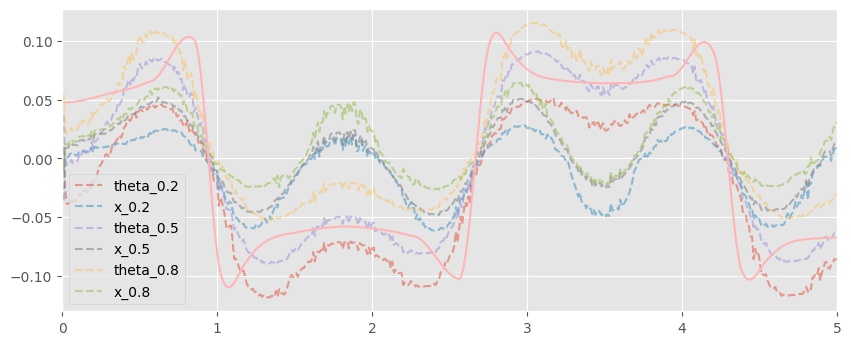

In [159]:
alpha = [0.2, 0.5, 0.8]
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
for a in alpha:
    pred = qr.predict(cdata.iloc[:len(t), [0, 2]], alpha=a)
    pred_df = pd.DataFrame(pred, columns=[f"{col}_{a}" for col in ["theta", "x"]])
    pred_df = pred_df.iloc[:-1]
    pred_df.index=t[1:]
    pred_df.plot(ax=ax, ls="--", alpha=0.5)
    display(pred_df.head())
# ax.plot(t, ((data - data.shift(1) - (data.shift(1) - data.shift(2)))).iloc[:len(t), 0])
ax.plot(t, (cdata.theta_d_.shift(-1) - cdata.theta_d_))
ax.set_xlim(0, 5)
# ax.set_xlim(20, 40)
plt.show()

In [160]:
from tqdm import tqdm


nsims = 50
sims = np.zeros((nsims, len(t), 2))
X0 = cdata.copy().iloc[0].to_numpy()
X0=cdata[["theta_", "x_"]].iloc[1].to_numpy()
X0_derv=X0 - cdata[["theta_", "x_"]].iloc[0].to_numpy()
X0 = np.concatenate((cdata[["theta_", "x_"]].iloc[1].to_numpy(), cdata[["theta_", "x_"]].iloc[1].to_numpy() - cdata[["theta_", "x_"]].iloc[0].to_numpy()))
for i in tqdm(range(nsims)):
    sims[i, ...] = qr.simulate_path(X0=X0, steps=len(t), sample=True, derv_inc=True)
    # sims[i, ...] = qr.simulate_path(X0=X0, steps=len(t), sample=True, X0_derv=X0_derv)
    # sims[i, ...] = qr.simulate_path(data.iloc[0].to_numpy(), len(t), sample=True)
    

100%|██████████| 50/50 [03:29<00:00,  4.18s/it]


In [161]:
median_sim = qr.simulate_path(X0=X0, steps=len(t), sample=False, derv_inc=True)

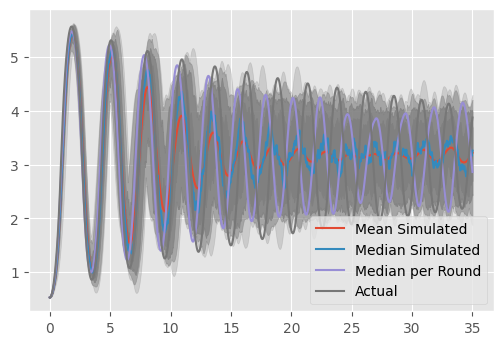

In [162]:

fig, ax = plt.subplots(dpi=100)
alpha = [0.5, 0.8, 0.95, 0.995]
for i, a in enumerate(reversed(sorted(alpha))):
    a2 = (1 - a) / 2
    ax.fill_between(t, y1=np.quantile(sims[..., 0], a2, axis=0), y2=np.quantile(sims[..., 0], 1 - a2, axis=0), alpha=0.25 * (i + 1), color="gray", label="")
# for i in range(nsims):
#     ax.plot(t, sims[i, :, 0], label="", c="gray", alpha=0.25)
ax.plot(t, sims[:, :, 0].mean(axis=0), label="Mean Simulated")
ax.plot(t, np.median(sims[:, :, 0], axis=0), label="Median Simulated")
ax.plot(t, median_sim[:, 0], label="Median per Round")
ax.plot(t, cdata.theta_.iloc[:], label="Actual")
ax.legend()
# ax.set_xlim(0,10)
plt.show()


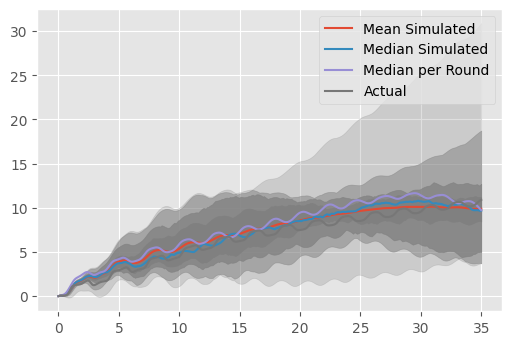

In [163]:
fig, ax = plt.subplots(dpi=100)
alpha = [0.5, 0.8, 0.95, 0.995]
for i, a in enumerate(reversed(sorted(alpha))):
    a2 = (1 - a) / 2
    ax.fill_between(t, y1=np.quantile(sims[..., 1], a2, axis=0), y2=np.quantile(sims[..., 1], 1 - a2, axis=0), alpha=0.25 * (i + 1), color="gray", label="")
# # for i in range(nsims):
# #     ax.plot(t, sims[i, :, 0], label="", c="gray", alpha=0.25)
ax.plot(t, sims[:, :, 1].mean(axis=0), label="Mean Simulated")
ax.plot(t, np.median(sims[:, :, 1], axis=0), label="Median Simulated")
ax.plot(t, median_sim[:, 1], label="Median per Round")
ax.plot(t, cdata.x_.iloc[:], label="Actual")
ax.legend()
plt.show()


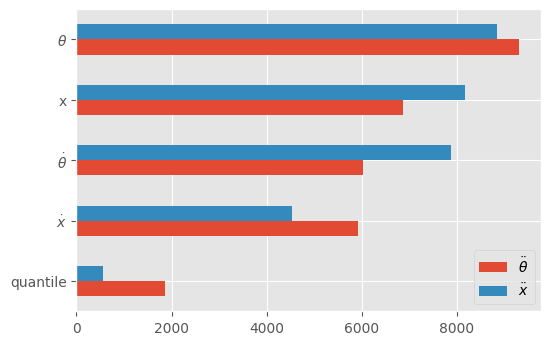

In [167]:
names = [r"$\theta$", "x", r"$\dot{\theta}$", r"$\dot{x}$", "quantile"]
fi_df = pd.DataFrame({
    r"$\ddot{\theta}$": qr.models[0].feature_importance(),
    r"$\ddot{x}$": qr.models[1].feature_importance(),
}, index=names)

fig, ax = plt.subplots(dpi=100)
fi_df.iloc[::-1].plot.barh(ax=ax)
plt.show()